In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline

In [3]:
nw = nx.grid_2d_graph(3, 3)

In [4]:
pos = {n: (n[0], -n[1]) for n in nw.nodes()}

In [5]:
pos

{(0, 0): (0, 0),
 (0, 1): (0, -1),
 (0, 2): (0, -2),
 (1, 0): (1, 0),
 (1, 1): (1, -1),
 (1, 2): (1, -2),
 (2, 0): (2, 0),
 (2, 1): (2, -1),
 (2, 2): (2, -2)}

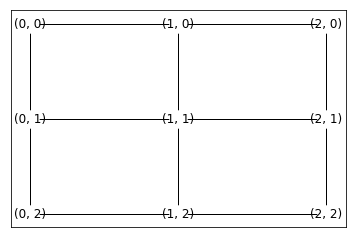

In [11]:
nx.draw_networkx(nw, pos=pos, node_color='w')
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.show()

In [21]:
[a for a in nw[(1, 1)] if isinstance(a, tuple)]

[(0, 1), (2, 1), (1, 0), (1, 2)]

In [19]:
edges = [e for e in nw.edges()]
print(len(edges))
edges = [e for e in edges if isinstance(e[0], tuple) and isinstance(e[1], tuple)]

print(edges)
len(edges)

12
[((0, 0), (1, 0)), ((0, 0), (0, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((0, 2), (1, 2)), ((1, 0), (2, 0)), ((1, 0), (1, 1)), ((1, 1), (2, 1)), ((1, 1), (1, 2)), ((1, 2), (2, 2)), ((2, 0), (2, 1)), ((2, 1), (2, 2))]


12

In [133]:
visible = nx.grid_2d_graph(28, 28)
# nx.set_node_attributes(visible, 10, 'value')
visible.nodes(data=True)[(0,0)]['value'] = 5

In [134]:
visible.nodes(data=True)

NodeDataView({(0, 0): {'value': 5}, (0, 1): {}, (0, 2): {}, (0, 3): {}, (0, 4): {}, (0, 5): {}, (0, 6): {}, (0, 7): {}, (0, 8): {}, (0, 9): {}, (0, 10): {}, (0, 11): {}, (0, 12): {}, (0, 13): {}, (0, 14): {}, (0, 15): {}, (0, 16): {}, (0, 17): {}, (0, 18): {}, (0, 19): {}, (0, 20): {}, (0, 21): {}, (0, 22): {}, (0, 23): {}, (0, 24): {}, (0, 25): {}, (0, 26): {}, (0, 27): {}, (1, 0): {}, (1, 1): {}, (1, 2): {}, (1, 3): {}, (1, 4): {}, (1, 5): {}, (1, 6): {}, (1, 7): {}, (1, 8): {}, (1, 9): {}, (1, 10): {}, (1, 11): {}, (1, 12): {}, (1, 13): {}, (1, 14): {}, (1, 15): {}, (1, 16): {}, (1, 17): {}, (1, 18): {}, (1, 19): {}, (1, 20): {}, (1, 21): {}, (1, 22): {}, (1, 23): {}, (1, 24): {}, (1, 25): {}, (1, 26): {}, (1, 27): {}, (2, 0): {}, (2, 1): {}, (2, 2): {}, (2, 3): {}, (2, 4): {}, (2, 5): {}, (2, 6): {}, (2, 7): {}, (2, 8): {}, (2, 9): {}, (2, 10): {}, (2, 11): {}, (2, 12): {}, (2, 13): {}, (2, 14): {}, (2, 15): {}, (2, 16): {}, (2, 17): {}, (2, 18): {}, (2, 19): {}, (2, 20): {}, (2, 2

In [121]:
nx.set_node_attributes(visible, 0 , 'value')

In [123]:
visible[(0,0)]['value']

KeyError: 'value'

In [8]:
class MRF(object):
    def __init__(self, input, theta=0.3, threshold=0.1):
        self.input = input
        self.shape = self.input.shape
        self.visible = nx.grid_2d_graph(self.shape[0], self.shape[1])
        self.hidden = nx.grid_2d_graph(self.shape[0], self.shape[1])
        
        for n in self.nodes():
#             self.visible[n]['value'] = self.input[n[0], n[1]]
            nx.set_node_attributes(self.visible, {n:self.input[n[0], n[1]]}, 'value')
            
            f = lambda: np.array([1.0, 1.0])
#             self.hidden[n]['messages'] = defaultdict(f)
#             nx.set_node_attributes(self.hidden, {n: defaultdict(f)}, 'messages')
            self.hidden.nodes[n]['messages'] = defaultdict(f)
        
        self.theta = theta
        self.threshold = threshold
        
    def nodes(self):
        for r in range(self.shape[0]):
            for c in range(self.shape[1]):
                yield (r, c)
    
    @property
    def denoised(self):
        for p in self.belief_propagation():
            pass
        
        denoised = np.copy(self.input)
        for r, c in self.nodes():
            prob = np.array([1.0, 1.0])
            messages = self.hidden.nodes[(r, c)]['messages']
            for value in messages.values():
                prob *= value
            denoised[r, c] = 0 if prob[0] > prob[1] else 1
        return denoised
    
    def send_message(self, source): 
        targets = [n for n in self.hidden[source] if isinstance(n, tuple)] # これでsourceの周辺隣接ノードのタプルが得られる
        diff = 0
        for target in targets:
            message = self.marginal(source, target) # 周辺尤度
            message /= np.sum(message) # 正規化
#             messages = self.hidden[target]['messages'] # targetの潜在変数に渡されている値
            messages = self.hidden.nodes[target]['messages']
            diff += np.sum(np.abs(messages[source] - message)) # sourceからの値(過去の値)と周辺尤度の差
            messages[source] = message # messageの更新
#             nx.set_node_attributes(self.hidden, {target: messges}, 'messages')
        return diff
    
    def marginal(self, source, target):
        m = np.array([0.0, 0.0])
        for i in range(2): # valueとして取りうる2値について
            prob = self.prob(i) # そのポテンシャル？
#             neighbors = self.hidden[source]['messages'].keys() # sourceの潜在変数ノードに渡されている値の送信元
            neighbors = self.hidden.nodes[source]['messages'].keys() # 一度でもmessageを受信した相手
            
#             print("DEBUG: mariginal neighbors:", source, target, neighbors,  [n for n in neighbors if n != target])
            
            for n in [n for n in neighbors if n != target]: # ターゲットは除く
#                 prob *= self.hidden[source]['messages'][n] #その値を掛け算する(尤度ベクトルの積をとるところ)
                prob *= self.hidden.nodes[source]['messages'][n]
            m[i] = np.sum(prob) # 周辺化なので，1である場合と0である場合のprobの和を返す?
            
        return m
    
    def belief_propagation(self, loop=20): # ここで確率伝搬する
        edges = [e for e in self.hidden.edges()] # ノード間のエッジ
        edges = [e for e in edges if isinstance(e[0], tuple) and isinstance(e[1], tuple)] # 何を除外しているのかよくわからない
        threshold = self.threshold * len(edges) # エッジの数*th がthreshold
        
        for n in self.nodes(): #n はノードの座標タプル
#             message = self.prob(self.visible[n]['value'])#観測ノードの値→ポテンシャル値？
            message = self.prob(nx.get_node_attributes(self.visible, 'value')[n])
            message /= np.sum(message) # 正規化
#             self.hidden[n]['messages'][n] = message # 潜在変数に伝搬
#             nx.set_node_attributes(self.hidden, {n : {n: message}}, 'messages')
            self.hidden.nodes(data=True)[n]['messages'][n] = message
        yield
        
        for i in range(loop):  #ここからループ
            diff = 0
            for n in self.nodes():
                diff += self.send_message(n) # 差分を加算．周辺尤度の差分が返ってくる
                yield
            
            if diff < threshold: # 閾値を超えたらbreak
                break
                
    def prob(self, value): # 値は，0である確率と1である分布のベクトル？
        base = np.array([1 + self.theta if value == 0 else 1 - self.theta,
                                        1 + self.theta if value == 1else 1 - self.theta])
        return base
    
def get_corrupted_input(img, corruption_level):
    corrupted = np.copy(img)
    inv = np.random.binomial(n=1, p=corruption_level, size=img.shape)
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            if inv[r, c]:
                corrupted[r, c] = ~(corrupted[r, c].astype(bool))
    return corrupted

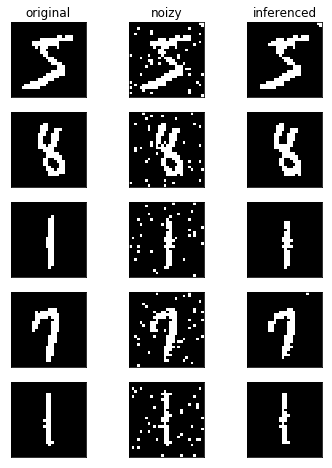

In [9]:
# MNIST データをダウンロード / ロード
from sklearn.datasets import fetch_mldata
from keras.datasets import mnist as MN

mnist = MN.load_data()[0][0]

import matplotlib.pyplot as plt
import matplotlib.cm as cm
fig, axes = plt.subplots(5, 3, figsize=(6, 8))

# サンプルデータをスライス
data = mnist[[0, 7000, 14000, 21000, 28000]]

for i, (axrow, img) in enumerate(zip(axes, data)):
    img = img.reshape(28, 28)
    # 2値画像に変換
    img = (img >= 128).astype(int)
    
    corrupted = get_corrupted_input(img, 0.05)
    
    mrf = MRF(corrupted)
    
    if i == 0:
        axes[i][0].set_title('original')
        axes[i][1].set_title('noizy')
        axes[i][2].set_title('inferenced')
    axes[i][0].imshow(img, cmap=cm.Greys_r)
    axes[i][1].imshow(mrf.input, cmap=cm.Greys_r)
    # MRF.denoised プロパティはノイズ除去した推測値を返す
    axes[i][2].imshow(mrf.denoised, cmap=cm.Greys_r)
    for ax in axrow:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
plt.show()